In [1]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random

In [2]:
# Suppress TensorFlow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel('ERROR')

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
# Create the environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the DQN agent
agent = DQNAgent(state_size, action_size)

# Training parameters
batch_size = 64
num_episodes = 100
max_steps_per_episode = 100

# Lists to store rewards for plotting
rewards_list = []
avg_rewards_list = []

for episode in range(num_episodes):
    state = env.reset()

    if isinstance(state, dict):
        state = np.array(list(state.values()), dtype=np.float32)
    elif isinstance(state, tuple):
        state = np.hstack([np.array(s, dtype=np.float32) for s in state if isinstance(s, np.ndarray)])
    else:
        state = np.array(state, dtype=np.float32)

    state = np.reshape(state, [1, state_size])

    total_reward = 0
    for t in range(max_steps_per_episode):
        action = agent.act(state)
        
        result = env.step(action)
        if len(result) == 4:
            next_state, reward, done, info = result
        else:
            next_state, reward, done, truncated, info = result
            done = done or truncated

        if isinstance(next_state, dict):
            next_state = np.array(list(next_state.values()), dtype=np.float32)
        elif isinstance(next_state, tuple):
            next_state = np.hstack([np.array(s, dtype=np.float32) for s in next_state if isinstance(s, np.ndarray)])
        else:
            next_state = np.array(next_state, dtype=np.float32)

        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    print(f"Episode: {episode}, Score: {total_reward}, Epsilon: {agent.epsilon:.2}")


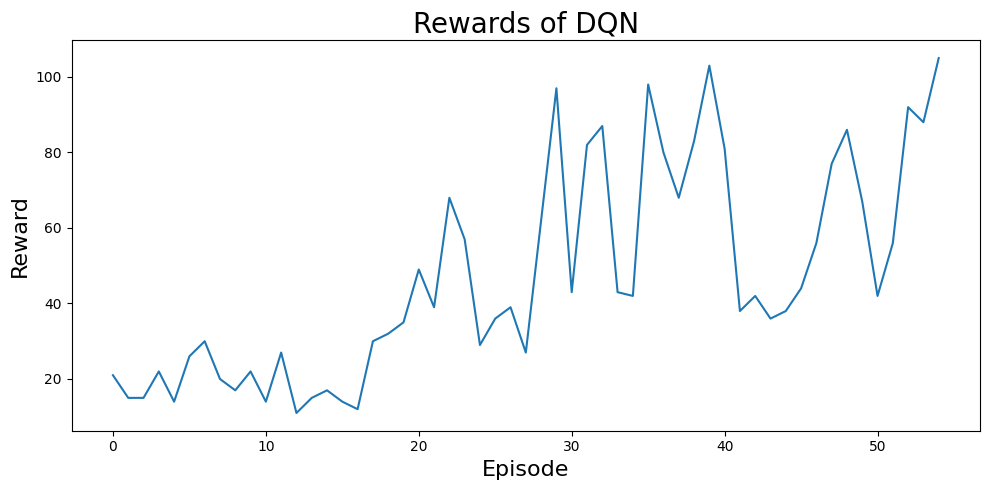

In [7]:
# Plotting graph
plt.figure(figsize=(10,5))

plt.plot(rewards_list)

plt.xlabel("Episode", fontsize=16)
plt.ylabel("Reward",  fontsize=16)
plt.title("Rewards of DQN",  fontsize=20)
plt.tight_layout()

plt.show()